# Machine Learning Techniques to predict Captions

## By Hiranmai Devarasetty and Arjun Pesaru

## Introduction

Image Caption Generation is a complex AI task that bridges computer vision and NLP. The objective is to generate textual descriptions for images, requiring the model to both understand visual content and express it in coherent language.



The importance of this project lies in its wide applications, including improving accessibility for visually impaired individuals, automating media tagging, and enhancing human-AI interaction. Using the robust VGG16 architecture ensures accurate feature extraction, forming the foundation for generating meaningful and contextually relevant captions.
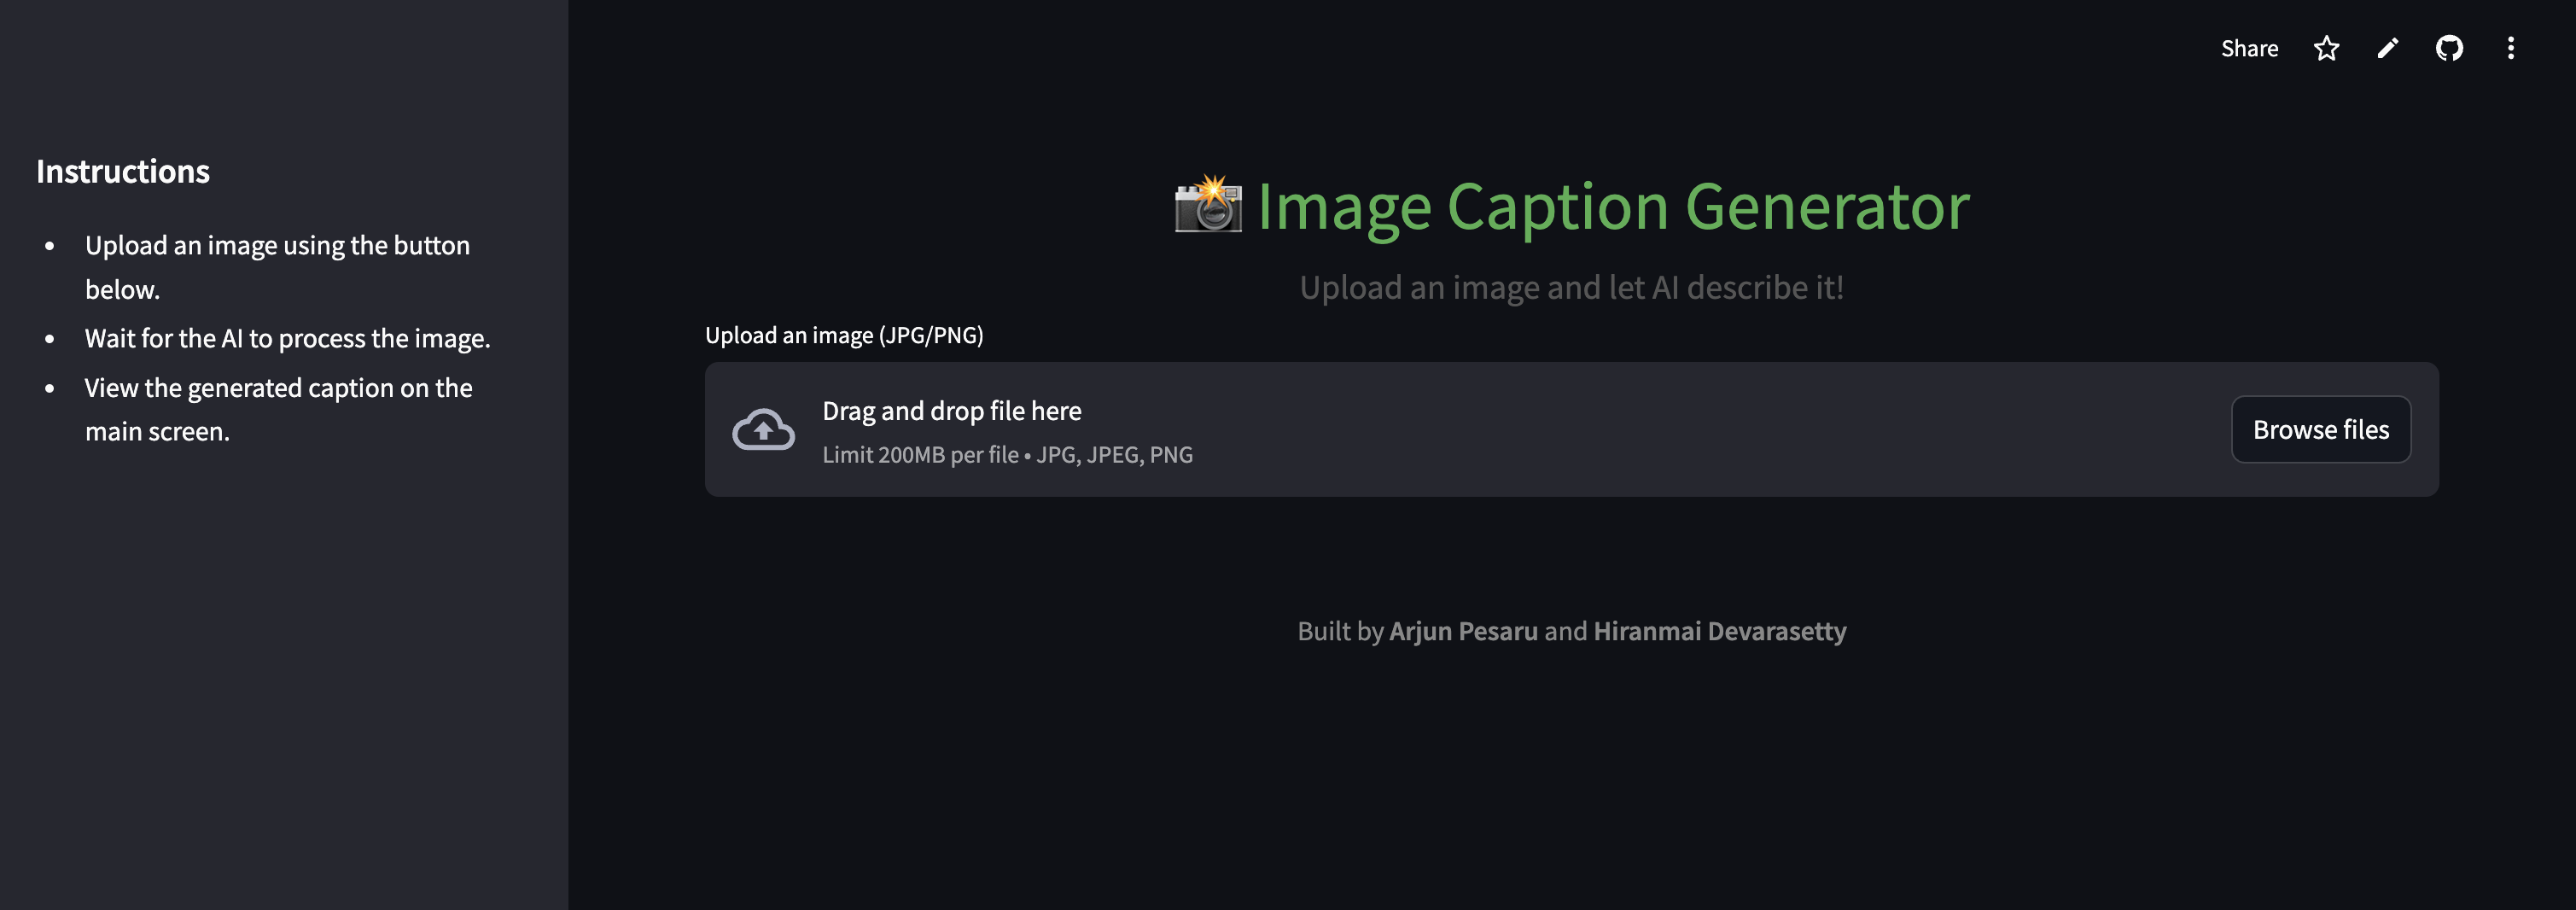

## Dataset

Dataset
The Flickr8k Dataset was used for this project. It includes:
8,091 images in JPEG format.
40,455 captions, with 5 captions per image.

Dataset Source: KAGGLE LINK https://www.kaggle.com/datasets/jaykumar2862/flicker-8k

# Model Details
# Implementation Approach

Image Feature Extraction

Utilized the VGG16 model, a pre-trained convolutional neural network, for feature extraction.
Removed the last fully connected layers to focus on image feature vectors.
Text Preprocessing

Cleaned captions by removing punctuation, single characters, and numeric tokens.
Added "startseq" and "endseq" tokens to mark the start and end of each caption.
Model Architecture

Encoder-Decoder Structure:
Encoder: Extracts features from images using VGG16.
Decoder: Utilizes an LSTM-based network for generating sequential text.
Attention Mechanism: Integrated for improving context awareness during generation.
Evaluation

Used the BLEU (Bilingual Evaluation Understudy) metric to assess model performance. BLEU scores compare the generated captions with reference captions.

## Model Evaluation matrix

BLEU (Bilingual Evaluation Understudy)

BLEU Score: Measures the overlap between generated and reference captions, with values ranging from 0 (no overlap) to 1 (perfect match).

The approach works by counting matching n-grams in the candidate translation to n-grams in the reference text, where 1-gram or unigram would be each token and a bigram comparison would be each word pair. The comparison is made regardless of word order.

*The Python Natural Language Toolkit library, or NLTK, provides an implementation of the BLEU score that you can use to evaluate your generated text against a reference.*

# Importance
This project has significant applications in accessibility tools, automated content tagging, and enhanced human-computer interaction. By integrating VGG16 and NLP techniques, it aims to push the boundaries of AI's ability to describe and interpret visual data.

### Importing necessary libraries

In [47]:
import tensorflow as tf
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter
warnings.filterwarnings("ignore")

print("python {}".format(sys.version))
print("tensorflow version {}".format(tf.__version__))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10240)]
        )
        print("GPU configured successfully.")
    except RuntimeError as e:
        print("Error configuring GPU:", e)

def set_seed(sd=123):
    from numpy.random import seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number
    rn.seed(sd)
    ## tensor flow's random number
    tf.random.set_seed(sd)


python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
tensorflow version 2.16.2


### Downloading and importing dataset in the notebook

In [48]:

dir_Flickr_jpg = r"/Users/arjunpesaru/Desktop/sml_p/Flickr_Data/Flickr_Data/Images"
dir_Flickr_text = r"/Users/arjunpesaru/Desktop/sml_p/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


## Preliminary Analysis

#### Importing Caption data

Load the text data and save it into a panda dataframe df_txt.

In [49]:

file = open(dir_Flickr_text,'r')
text = file.read()
file.close()
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])
df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

In [50]:
df_txt[:6]

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   
5  1001773457_577c3a7d70.jpg     0   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  
5         a black dog and a spotted dog are fighting

### Example pictures with captions

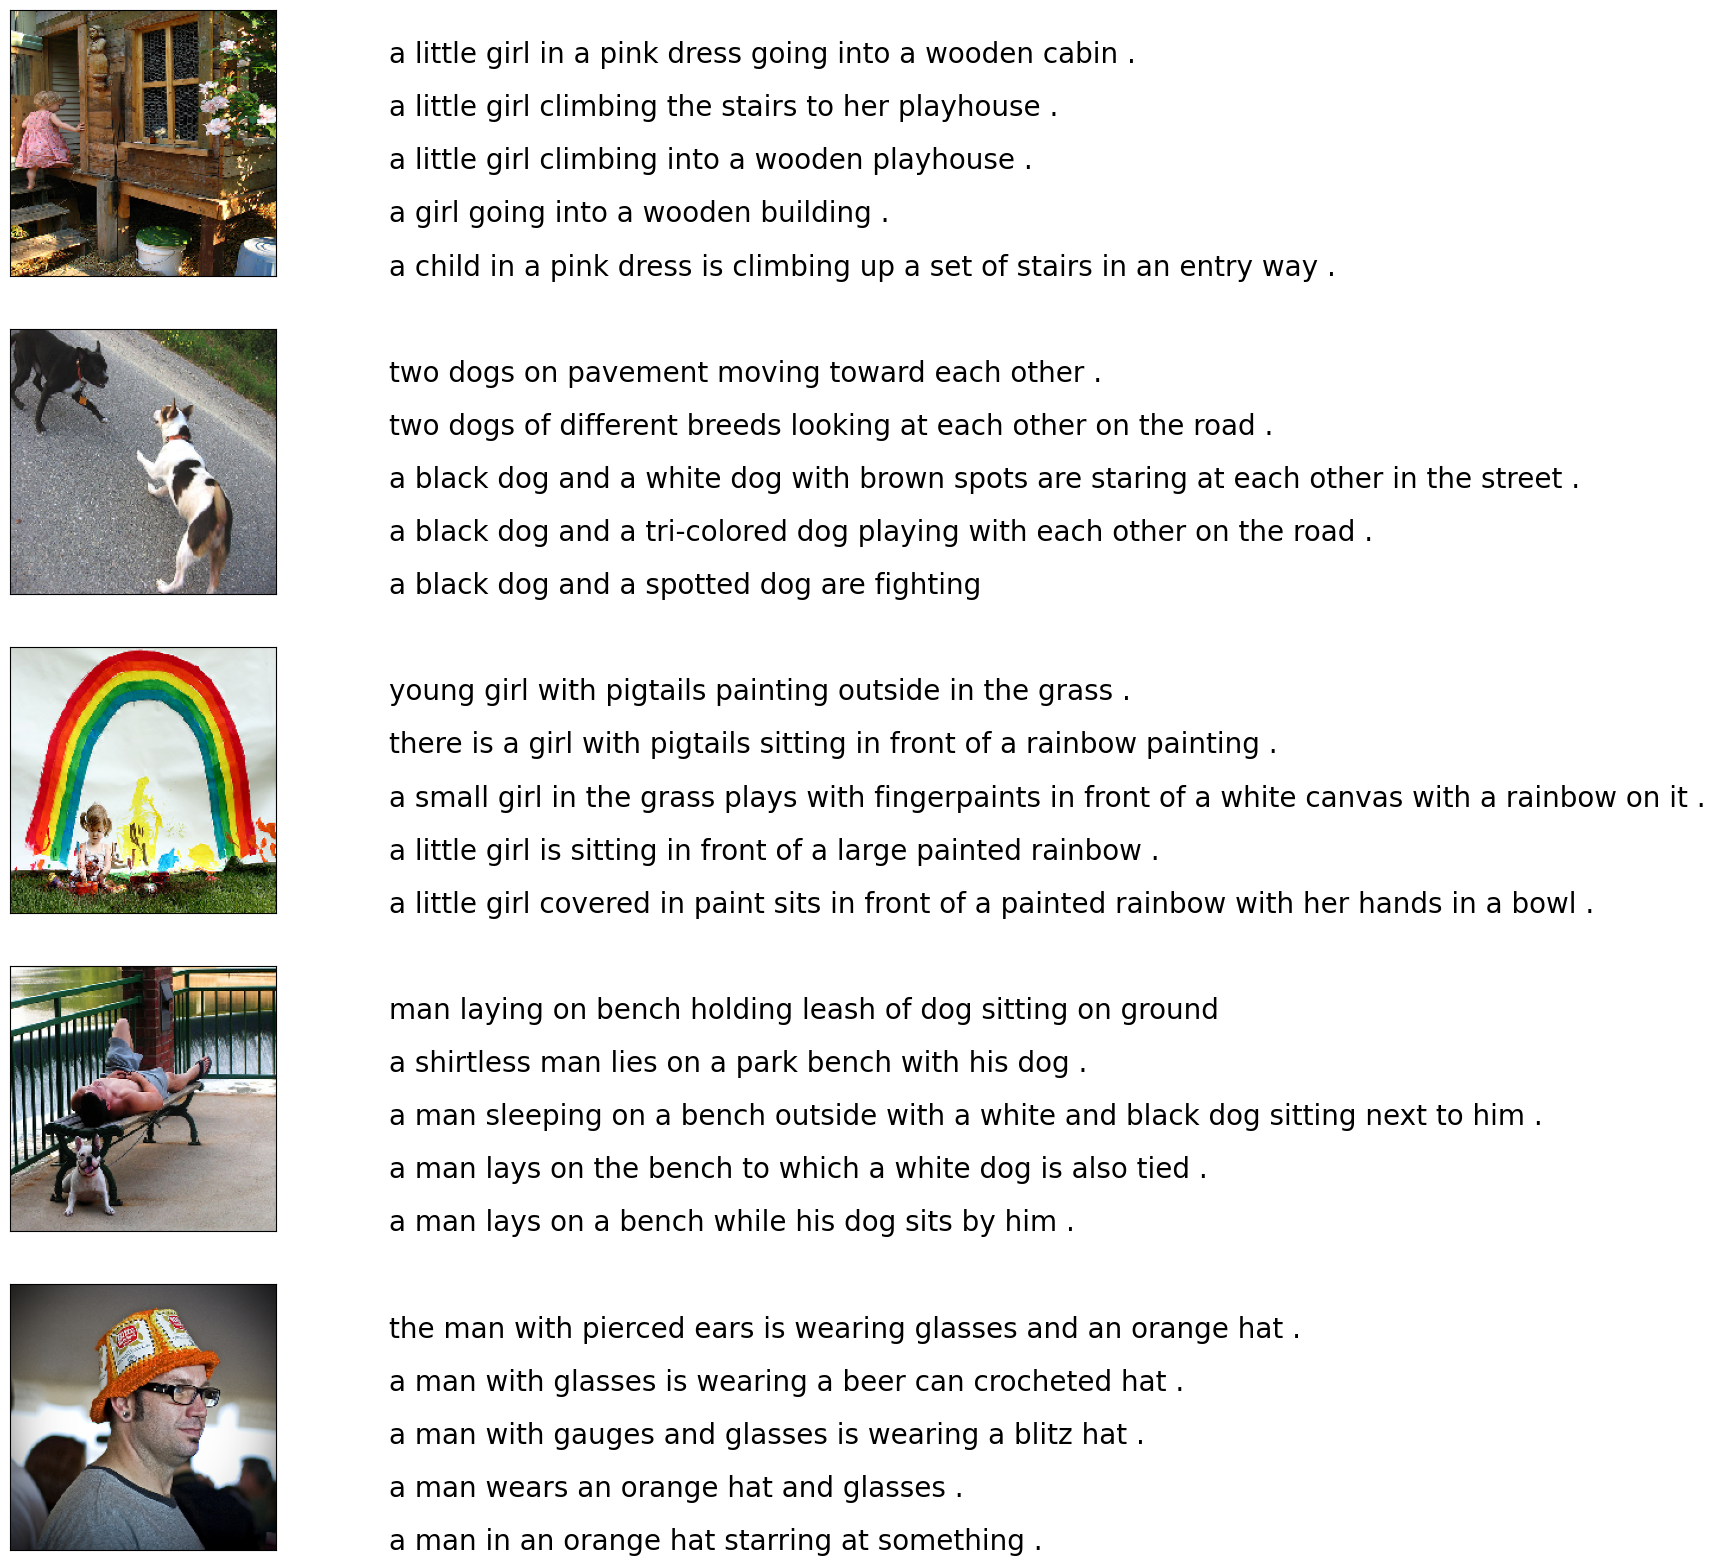

In [51]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## Data Preparation

We create a new dataframe dfword to visualize distribution of the words. It contains each word and its frequency in the entire tokens in decreasing order.

In [52]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame(list(ct.items()), columns=['word', 'count'])
    dfword.sort_values(by='count', ascending=False, inplace=True)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975

#### The most and least frequently appearing words

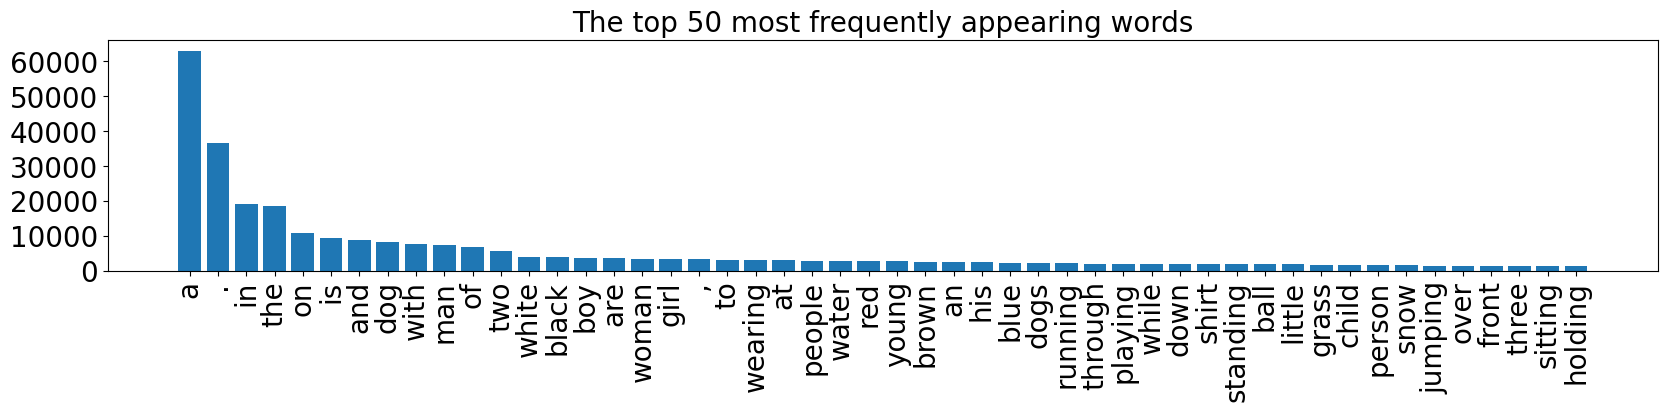

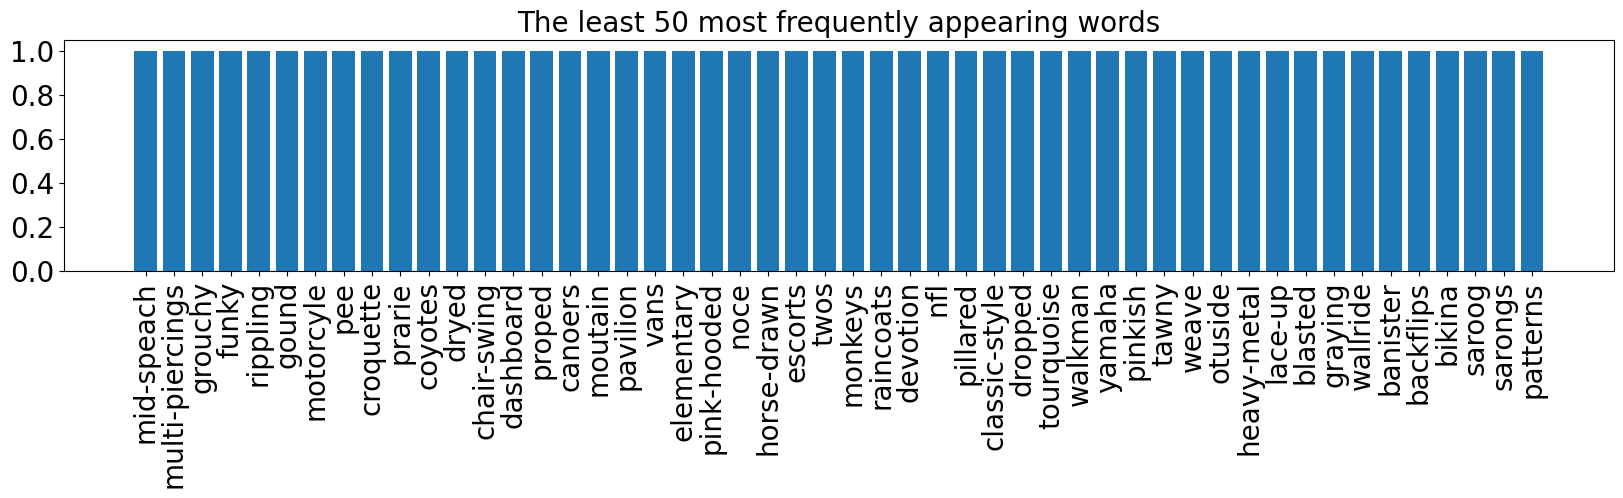

In [53]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

Inference: The most frequently occurring words include articles like "a" and "the" as well as punctuation marks.

To ensure these elements do not adversely impact the model's performance (as they can sometimes introduce bias), three functions will be implemented to:

Remove punctuation.
Eliminate single-character words.
Exclude numeric characters.

#### Cleaning example string using these 3 functions

In [54]:
import string
text_original = "The cat ran 5 miles in 2 hours! Then it slept for 10 hours. Can you believe it?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('', '', string.punctuation))
    return text_no_punctuation
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return text_len_more_than1
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text, printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word, isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return text_no_numeric
text_no_numeric = remove_numeric(text_len_more_than1, printTF=True)
print(text_no_numeric)


The cat ran 5 miles in 2 hours! Then it slept for 10 hours. Can you believe it?

Remove punctuations..
The cat ran 5 miles in 2 hours Then it slept for 10 hours Can you believe it

Remove a single character word..
 The cat ran miles in hours Then it slept for 10 hours Can you believe it

Remove words with numeric values..
    The        : True
    cat        : True
    ran        : True
    miles      : True
    in         : True
    hours      : True
    Then       : True
    it         : True
    slept      : True
    for        : True
    10         : False
    hours      : True
    Can        : True
    you        : True
    believe    : True
    it         : True
 The cat ran miles in hours Then it slept for hours Can you believe it


### Cleaning all captions in dataset

Using the 3 functions, we will clean all captions

In [55]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

After cleaning our vocabulary size is significantly reduced by around 200 words.

#### Now, after cleaning the caption list of 50 most occurring and least occurring words

Vocabulary Size: 8763


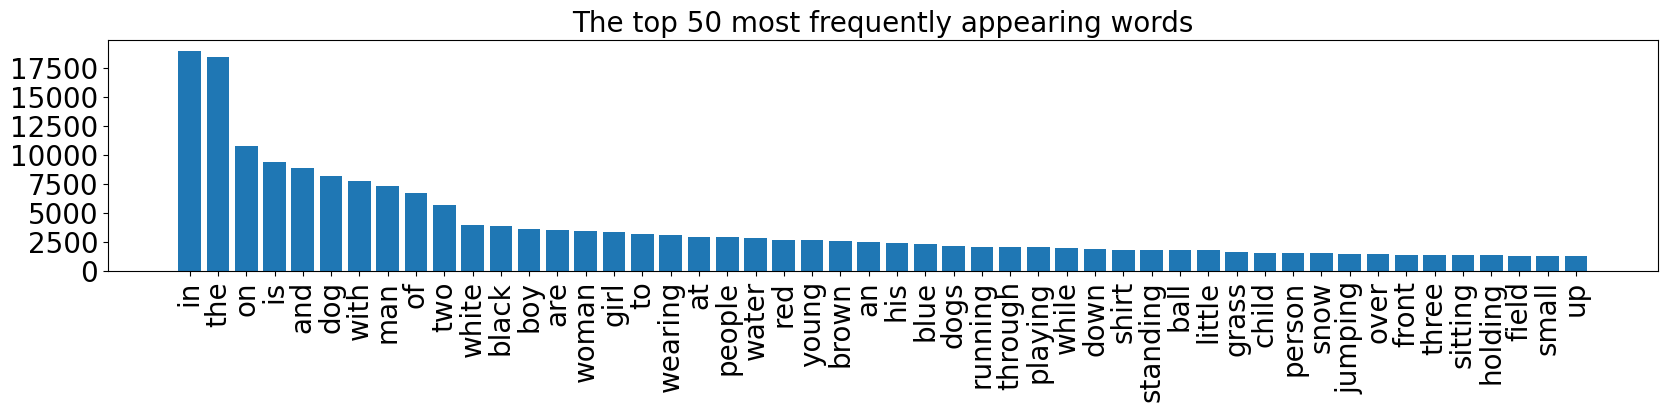

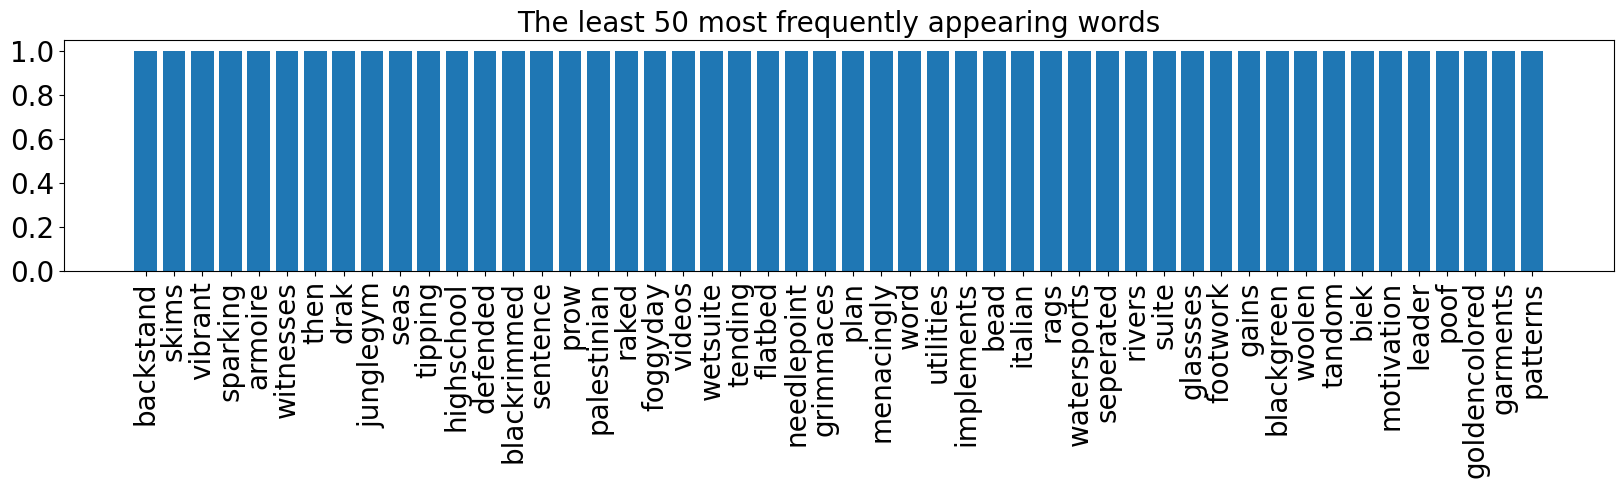

In [56]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

### Adding Start and End sequence tokens in every caption

In [57]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

## Image Preparation for the VGG16 Model

We will be using pre-trained network VGG16. This model takes input image of size (224, 224, 3).

We choose this model because it achieves 92.7% (top-5 test accuracy) in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

#### Double-click __here__ for the source of Model.

<!--
'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
-->

In [58]:
modelvgg = tf.keras.applications.VGG16(include_top=True, weights=None)
modelvgg.load_weights(r"/Users/arjunpesaru/Desktop/sml_p/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

__VGG16 is developed to classify images into 1,000 different classes. As we are not using VGG16 for the sake of the classification but we just need it for extracting features, we will remove the last layer from the network.__

In [59]:
modelvgg.layers.pop()
modelvgg = tf.keras.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
modelvgg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

### Transforming images to features using model

In [60]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from tensorflow.keras.models import load_model
images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs[:8092]):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [61]:
images['1000268201_693b08cb0e.jpg']

array([2.507648, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
      dtype=float32)

In [62]:
len(images)

8091

### Linking the text and image data

In [63]:
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

In [64]:
dimages.shape

(8091, 4096)

In [65]:
dcaptions[:5]

array(['startseq  child in pink dress is climbing up set of stairs in an entry way endseq',
       'startseq  black dog and spotted dog are fighting endseq',
       'startseq  little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
       'startseq  man lays on bench while his dog sits by him endseq',
       'startseq  man in an orange hat starring at something endseq'],
      dtype=object)

## Tokenizer

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
nb_words = 8000

tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)

vocabulary size : 4476


In [67]:
dtexts[:5]

[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2],
 [1, 12, 8, 5, 752, 8, 17, 368, 2],
 [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2],
 [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2],
 [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]

In [68]:
import pickle

with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Spliting the dataset into training and testing

In [69]:
prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])
dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [70]:
maxlen = np.max([len(text) for text in dtexts])

In [71]:
from keras.utils import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


In [72]:
Xtext_train[:14]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1,   75],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,   75,   38],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,   75,   38,   33],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1, 

In [73]:
Ximage_train.shape

(49631, 4096)

In [74]:
ytext_train.shape

(49631, 4476)

## Model

In [75]:
Ximage_train.shape[1]

4096

In [82]:
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout, AdditiveAttention
from tensorflow.keras.optimizers import Adam

print(vocab_size)

dim_embedding = 64

# Image feature extraction
input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01), name="ImageFeature")(input_image)
fimage = BatchNormalization()(fimage)

# Text embedding and feature extraction
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01), name="CaptionFeature")(ftxt)
ftxt = BatchNormalization()(ftxt)

# Attention mechanism
attention = AdditiveAttention(name="AttentionLayer")([fimage, ftxt])

# Decoder
decoder = layers.Concatenate()([attention, fimage, ftxt])
decoder = layers.Dense(256, activation='relu')(decoder)
decoder = Dropout(0.3)(decoder)
decoder = BatchNormalization()(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)

# Compile the model
model = tf.keras.Model(inputs=[input_image, input_txt], outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

print(model.summary())


4476


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 30, 64)    │    286,464 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 30)        │          0 │ input_layer_11[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImageFeature        │ (None, 256)       │  1,048,832 │ input_layer_10[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CaptionFeature      │ (None, 256)       │    328,704 │ embedding_4[0][0… │
│ (LSTM)              │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ ImageFeature[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ CaptionFeature[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AttentionLayer      │ (None, 256)       │        256 │ batch_normalizat… │
│ (AdditiveAttention) │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 768)       │          0 │ AttentionLayer[0… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    196,864 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_4[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4476)      │  1,150,332 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,014,524 (11.50 MB)

 Trainable params: 3,012,988 (11.49 MB)

 Non-trainable params: 1,536 (6.00 KB)

None


__We are giving our model an image and a word (Ximage_train & Xtext_train respectively) and we want it to predict the next word for it which is our target ytext_train__

In [83]:

print(Ximage_train[0])
print(Xtext_train[0])

[2.9835706  0.         0.22122514 ... 0.         0.         0.        ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [84]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, CSVLogger
import time

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5, 
    patience=2, 
    min_lr=1e-6, 
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3, 
    restore_best_weights=True, 
    verbose=1
)
csv_logger = CSVLogger('training_log.csv', append=True)  # Logs training progress to a file

start = time.time()

# Training with callbacks
hist = model.fit(
    [Ximage_train, Xtext_train], 
    ytext_train,
    epochs=20,  
    verbose=2, 
    batch_size=128,  
    validation_data=([Ximage_val, Xtext_val], ytext_val),  
    callbacks=[reduce_lr, early_stopping, csv_logger]
)

end = time.time()
print("TIME TOOK {:3.2f} MIN".format((end - start) / 60))


Epoch 1/20
388/388 - 36s - 94ms/step - loss: 11.5765 - val_loss: 9.5991 - learning_rate: 1.0000e-04
Epoch 2/20
388/388 - 34s - 88ms/step - loss: 7.9363 - val_loss: 7.0329 - learning_rate: 1.0000e-04
Epoch 3/20
388/388 - 33s - 86ms/step - loss: 6.4682 - val_loss: 6.0055 - learning_rate: 1.0000e-04
Epoch 4/20
388/388 - 34s - 88ms/step - loss: 5.7006 - val_loss: 5.5112 - learning_rate: 1.0000e-04
Epoch 5/20
388/388 - 36s - 92ms/step - loss: 5.2462 - val_loss: 5.2259 - learning_rate: 1.0000e-04
Epoch 6/20
388/388 - 36s - 92ms/step - loss: 4.9401 - val_loss: 5.0603 - learning_rate: 1.0000e-04
Epoch 7/20
388/388 - 35s - 89ms/step - loss: 4.6926 - val_loss: 4.8939 - learning_rate: 1.0000e-04
Epoch 8/20
388/388 - 35s - 90ms/step - loss: 4.4808 - val_loss: 4.7660 - learning_rate: 1.0000e-04
Epoch 9/20
388/388 - 35s - 89ms/step - loss: 4.3088 - val_loss: 4.6946 - learning_rate: 1.0000e-04
Epoch 10/20
388/388 - 35s - 90ms/step - loss: 4.1652 - val_loss: 4.6374 - learning_rate: 1.0000e-04
Epoch 11

In [85]:
model.save("/Users/arjunpesaru/Desktop/sml_p/my_model.keras")


In [86]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(49631, 4096) (49631, 30) (49631, 4476)


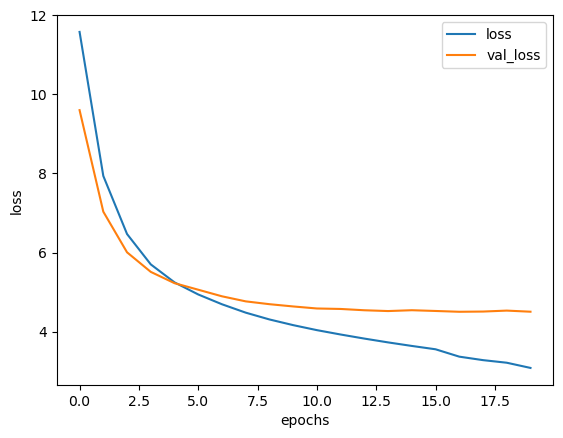

In [87]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

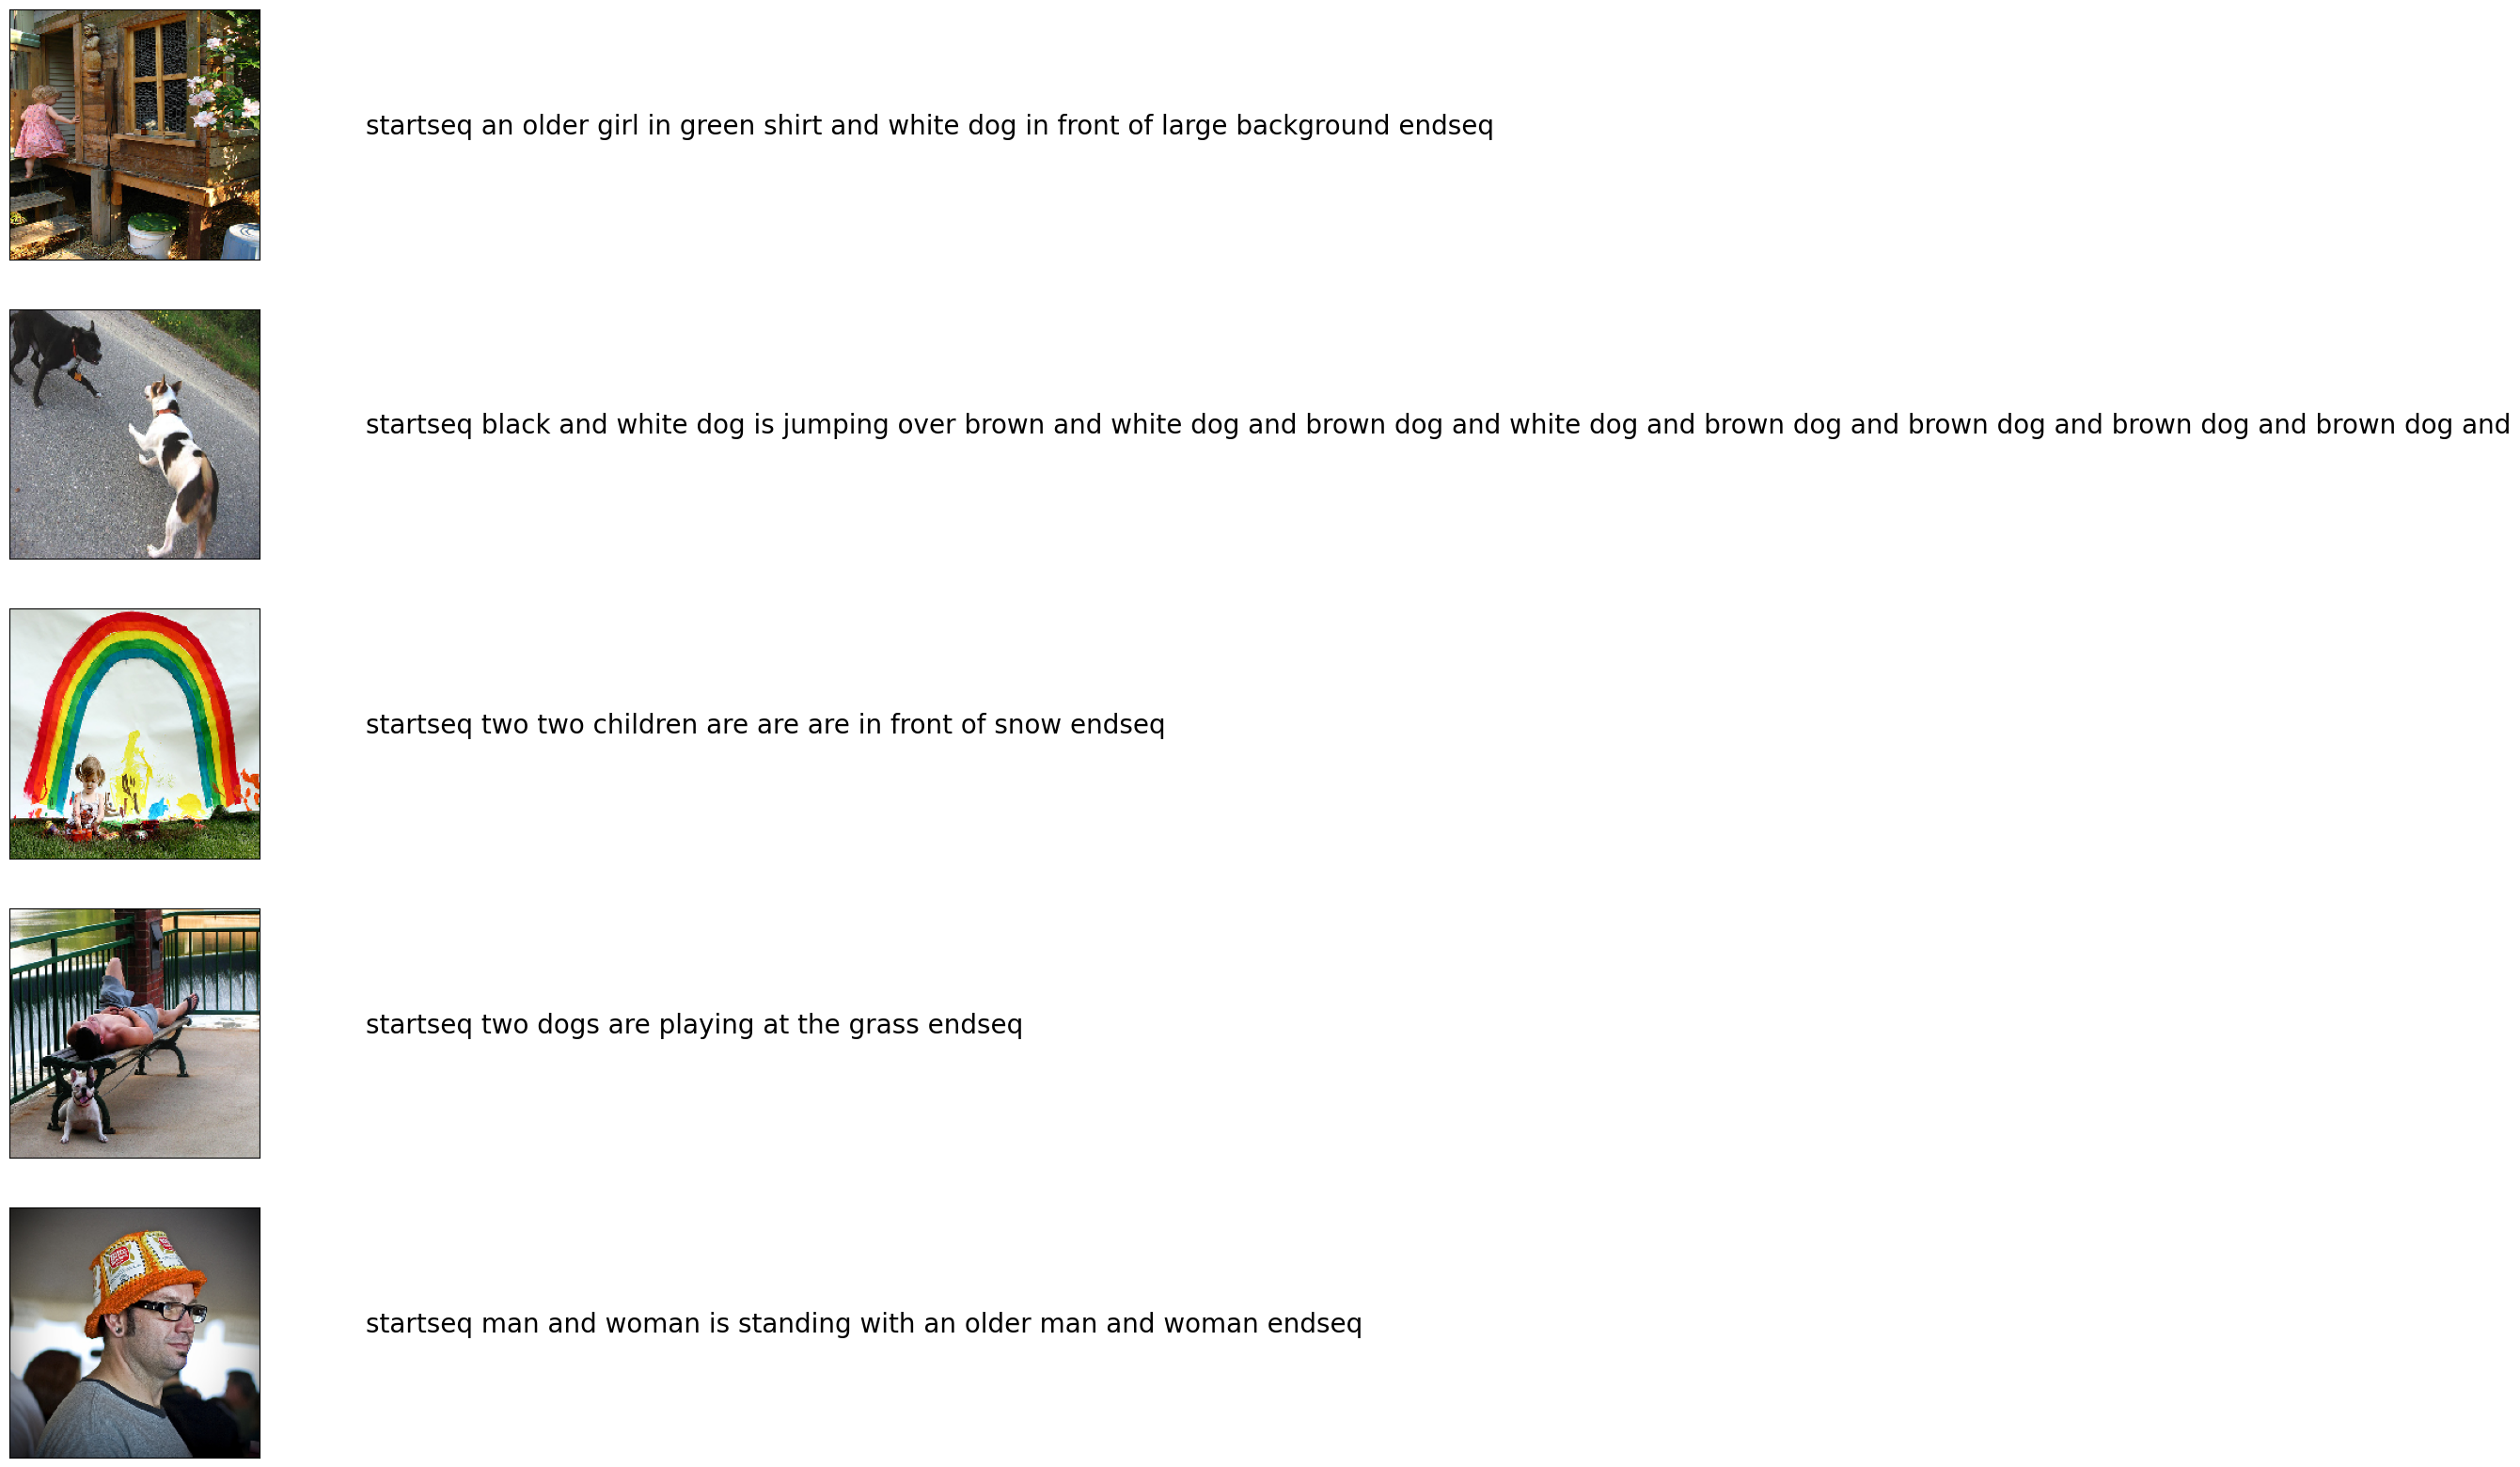

In [88]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [89]:
images['1000268201_693b08cb0e.jpg'].shape

(4096,)

## BLEU SCORE

In [90]:
start = time.time()

from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

smoothie = SmoothingFunction().method4
nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    bleu = sentence_bleu([caption_true],caption,smoothing_function=smoothie)
    bleus.append(bleu)
    if bleu > 0.6 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))
        
end = time.time()
print((start-end)/60)

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..
-10.079697453975678


In [91]:
pred_good


[(0.6147881529512643,
  '1117972841_2b9261f95f.jpg',
  ['brown', 'dog', 'is', 'running', 'in', 'the', 'sand'],
  ['brown', 'dog', 'is', 'running', 'in', 'its', 'mouth']),
 (0.6389431042462724,
  '1119418776_58e4b93eac.jpg',
  ['black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'field'],
  ['black',
   'and',
   'white',
   'dog',
   'is',
   'running',
   'through',
   'grassy',
   'grassy',
   'grass']),
 (0.6434588841607617,
  '1361420539_e9599c60ae.jpg',
  ['black', 'dog', 'is', 'running', 'in', 'the', 'grass'],
  ['black', 'dog', 'is', 'running', 'in', 'grassy', 'grass'])]

In [92]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.042


In [96]:
good_bleus = [entry[0] for entry in pred_good]  

mean_good_bleu = np.mean(good_bleus) if good_bleus else 0 
print("Mean BLEU for Good Predictions: {:4.3f}".format(mean_good_bleu))


Mean BLEU for Good Predictions: 0.632


Good Caption


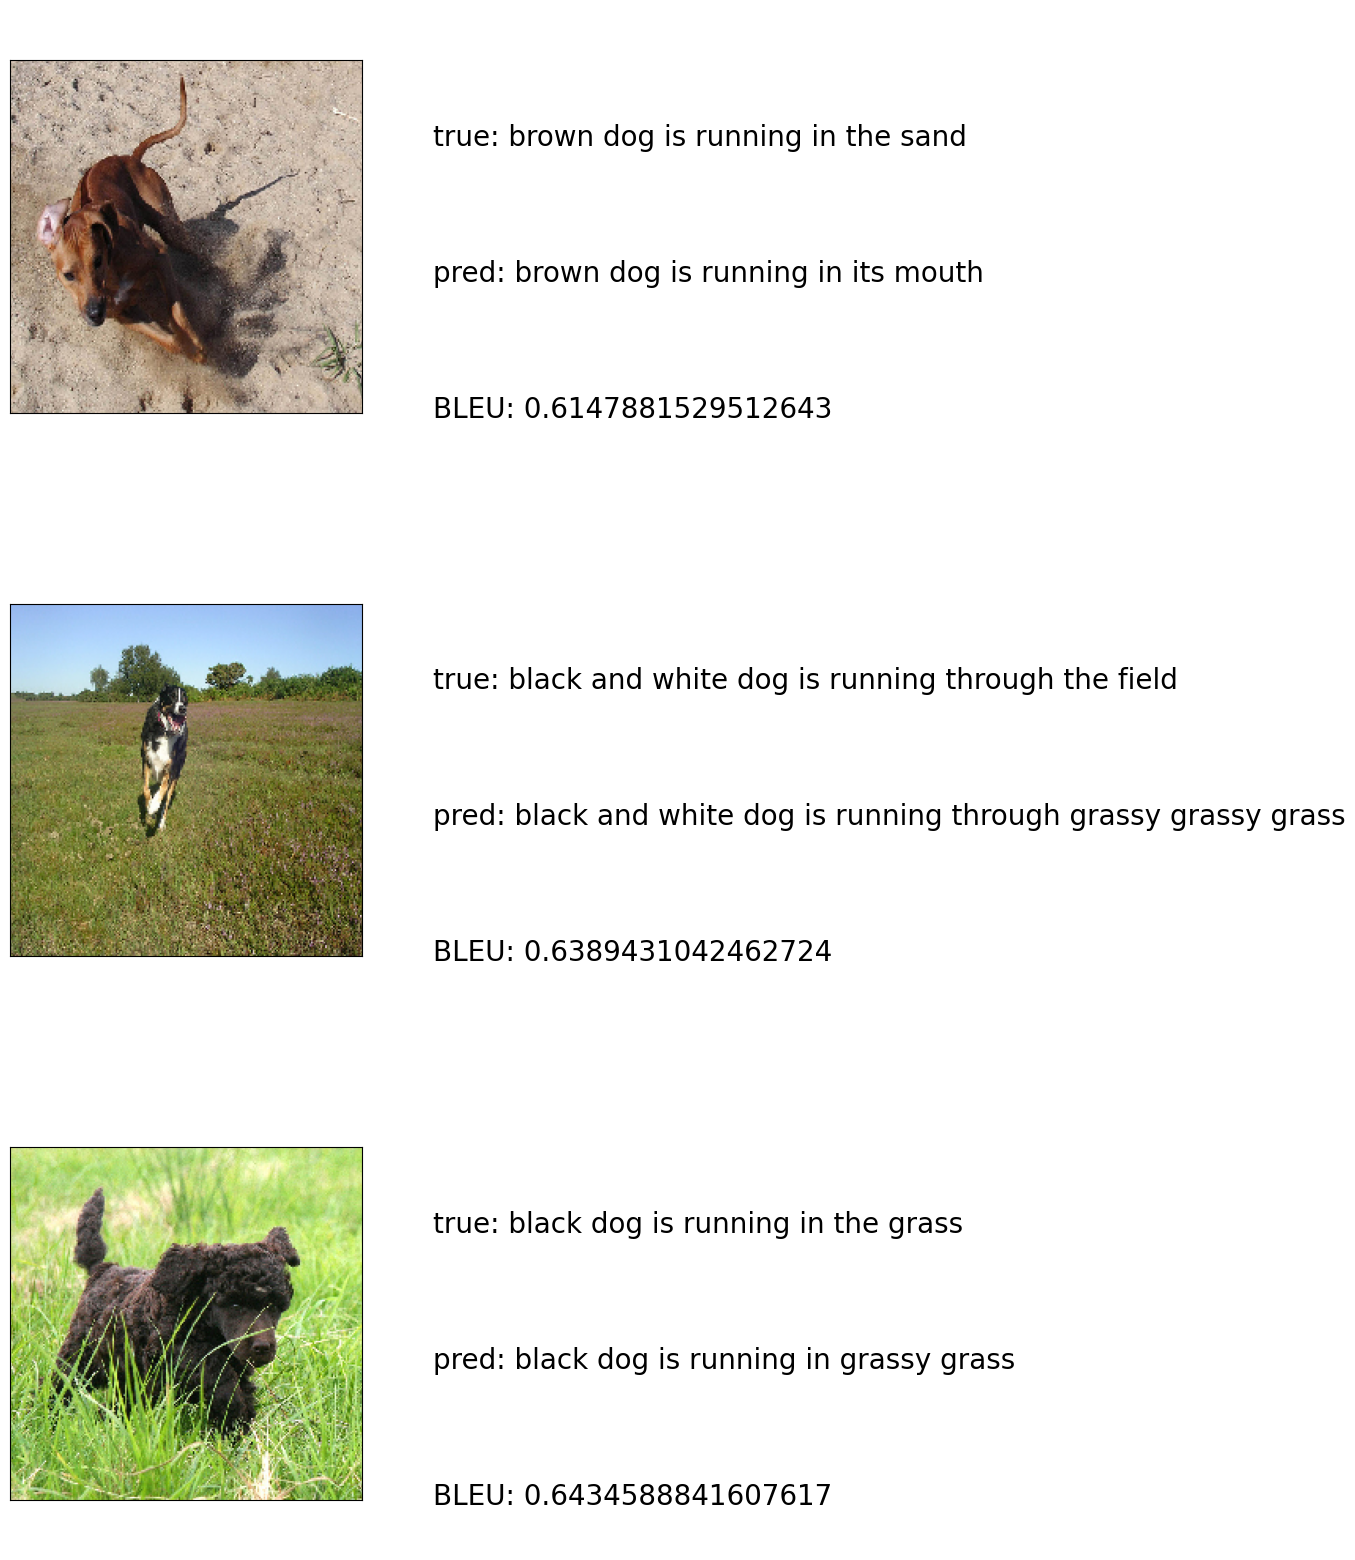

In [97]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()
print("Good Caption")
plot_images(pred_good)